In [1]:
n_e=10

Downloading the dataset

In [2]:
!wget http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz

--2021-11-19 01:33:07--  http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Resolving www.inf.ufpr.br (www.inf.ufpr.br)... 200.17.202.113, 2801:82:80ff:8001:216:ccff:feaa:79
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz [following]
--2021-11-19 01:33:08--  https://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz
Connecting to www.inf.ufpr.br (www.inf.ufpr.br)|200.17.202.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4273561758 (4.0G) [application/octet-stream]
Saving to: ‘BreaKHis_v1.tar.gz’

BreaKHis_v1.tar.gz  100%[===================>]   3.98G  20.0MB/s    in 3m 26s  

2021-11-19 01:36:35 (19.8 MB/s) - ‘BreaKHis_v1.tar.gz’ saved [4273561758/4273561758]



Extracting the datset

In [3]:
!tar -xf BreaKHis_v1.tar.gz

In [4]:
#imports for dataset preparation
import shutil
import os
import random
import shutil


In [5]:
# copy all the files in the subfolders to main folder
 
# The current working directory
dest_dir = '/content/BreaKHis_v1/'
# The generator that walks over the folder tree
walker = os.walk(dest_dir)
 
# the first walk would be the same main directory
# which if processed, is
# redundant
# and raises shutil.Error
# as the file already exists
 
rem_dirs = next(walker)[1]
 
for data in walker:
  for files in data[2]:
    try:
      shutil.move(data[0] + os.sep + files, dest_dir)
    except shutil.Error:
    # still to be on the safe side
      continue
 
# clearing the directories
# from whom we have just removed the files
for dirs in rem_dirs:
  shutil.rmtree(dest_dir + os.sep + dirs)

In [6]:
images = os.listdir('/content/BreaKHis_v1')

In [7]:
b_images=[]
m_images=[]
error_f=0
for i in images:
  if i[4]=='B' and i[-3:] =='png':
    b_images.append(i)
  elif i[4]=='M' and i[-3:] =='png':
    m_images.append(i)
  else:
    error_f+=1
print(error_f)

13


In [8]:
random.shuffle(b_images)
random.shuffle(m_images)

test_size   = 0.2
test_b_size = int(test_size*len(b_images))
test_m_size = int(test_size*len(m_images))


test_b  = b_images[ :test_b_size] 
train_b = b_images[test_b_size: ] 


test_m  = m_images[ :test_m_size] 
train_m = m_images[test_m_size: ]

In [9]:
print(len(test_b))
print(len(train_b))

print()

print(len(m_images))
print(len(test_m))
print(len(train_m))

496
1984

5429
1085
4344


Making Train and Test folders each having both the classes each

In [10]:
os.mkdir('/content/BreaKHis_v1/Train')
os.mkdir('/content/BreaKHis_v1/Test')

os.mkdir('/content/BreaKHis_v1/Train/benign')
os.mkdir('/content/BreaKHis_v1/Train/malignant')
os.mkdir('/content/BreaKHis_v1/Test/benign')
os.mkdir('/content/BreaKHis_v1/Test/malignant')

In [11]:
base_path = '/content/BreaKHis_v1'


for i in test_b:
  path = os.path.join(base_path,i)
  shutil.move(path,'/content/BreaKHis_v1/Test/benign')

for i in train_b:
  path = os.path.join(base_path,i)
  shutil.move(path,'/content/BreaKHis_v1/Train/benign')


for i in test_m:
  path = os.path.join(base_path,i)
  shutil.move(path,'/content/BreaKHis_v1/Test/malignant')

for i in train_m:
  path = os.path.join(base_path,i)
  shutil.move(path,'/content/BreaKHis_v1/Train/malignant')

In [12]:
########################
#          |           #
#---Dataset Prepared---#
#          |           #
########################

Training CNN models

In [13]:
#importing libraries

import os
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


%matplotlib inline

In [14]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'
else:
    print('CUDA is not available.  Training on CPU ...')
    device = 'cpu'

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [15]:
dataset_dir = '/content/BreaKHis_v1'
train_dir = os.path.join(dataset_dir, 'Train/')
test_dir = os.path.join(dataset_dir, 'Test/')
valid_dir = os.path.join(dataset_dir, 'Test/')

classes = ['Benign', 'Malignant']
print("Classes: ",classes)
print("Total no. of classes = ",len(classes))

Classes:  ['Benign', 'Malignant']
Total no. of classes =  2


In [16]:
#Defining our transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


# loading and applyling above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
test_dataset  = datasets.ImageFolder(test_dir ,transform=test_transforms)
valid_dataset = datasets.ImageFolder(valid_dir,transform=valid_transforms)


# printing out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  6328
Testing   images:  1581
Validation images: 1581


In [17]:
# define dataloader parameters
batch_size = 64
num_workers=0

# prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size*4, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size*4, num_workers=num_workers, shuffle = False)

In [18]:
#printing batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 99
Number of  testing   batches: 7
Number of validation batches: 7


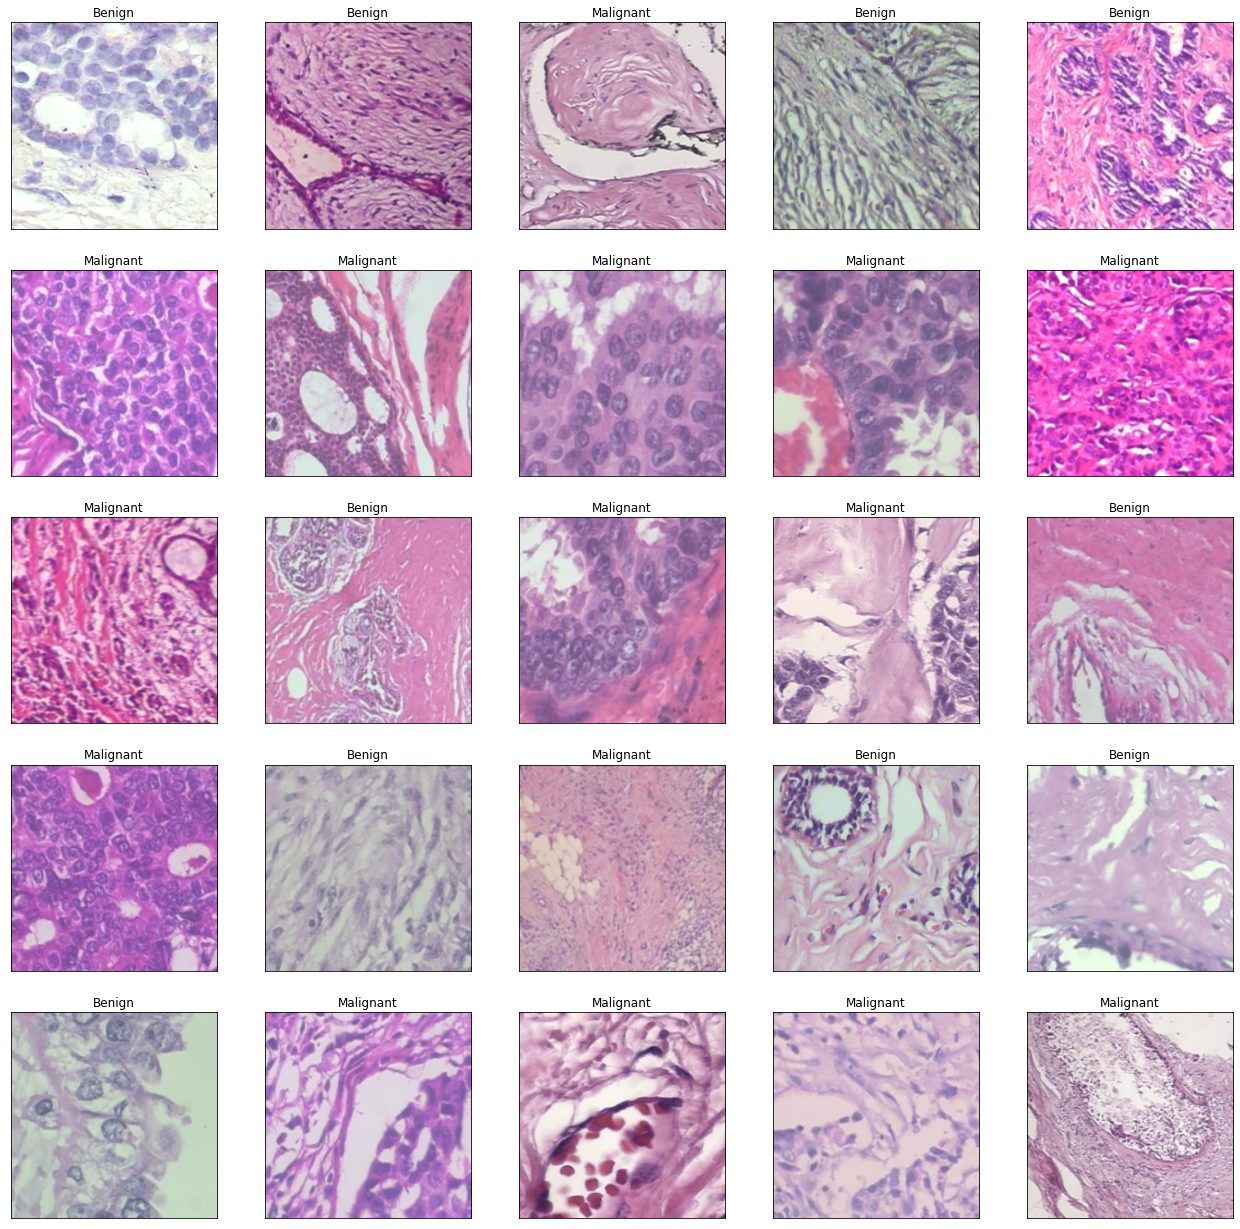

In [19]:
#only for visualizing the data
#ignoring normalization and turning shuffle ON to visualize different classes together
#Using train directory images can be used for visualization
visual_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])
visual_dataset  = datasets.ImageFolder(train_dir ,transform=visual_transforms)
visualization_dataloader=torch.utils.data.DataLoader(visual_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)

# Visualizing some data

# obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images = images.numpy() # converting images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(22, 22))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [20]:
model_names= ['alexnet', 'vgg19', 'resnet152', 'densenet201']
print("Models To be Used:")
for m in model_names:
  print(m)

Models To be Used:
alexnet
vgg19
resnet152
densenet201


In [21]:
def train_cnn_model(model_name, n_epochs=1):
  if model_name=='alexnet':
    # print out the model structure
    print("###########################################################################")
    model = models.alexnet(pretrained=True)
    print("Model Name: ",model_name,end="\n\n")
    print(model)
    print("Last layer input features: ",model.classifier[6].in_features) 
    print("Last layer output features: ",model.classifier[6].out_features) 
    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = False

    n_inputs = model.classifier[6].in_features

    # add last linear layer (n_inputs --to---> 14 painting classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes)) 

    model.classifier[6]= last_layer

    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model=model.to(device)

    # check to see that your last layer produces the expected number of outputs
    print("Last layer output features (after changes): ",model.classifier[6].out_features)

    # specifying optimizer and learning rate
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

  elif model_name=='vgg19':
    # print out the model structure
    print("###########################################################################")
    model = models.vgg19(pretrained=True)
    print("Model Name: ",model_name,end="\n\n")
    print(model)
    print("Last layer input features: ",model.classifier[6].in_features) 
    print("Last layer output features: ",model.classifier[6].out_features) 
    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = False
    
    n_inputs = model.classifier[6].in_features

    # add last linear layer (n_inputs --to---> 14 painting classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes)) 

    model.classifier[6]= last_layer

    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model=model.to(device)

    # check to see that your last layer produces the expected number of outputs
    print("Last layer output features (after changes): ",model.classifier[6].out_features)

    # specifying optimizer and learning rate
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    
  elif model_name=='resnet152':
    # print out the model structure
    print("###########################################################################")
    model = models.resnet152(pretrained=True)
    print("Model Name: ",model_name,end="\n\n")
    print(model)
    print("Last layer input features: ",model.fc.in_features) 
    print("Last layer output features: ",model.fc.out_features) 
    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = False
    
    n_inputs = model.fc.in_features

    # add last linear layer (n_inputs --to---> 14 painting classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes)) 

    model.fc= last_layer

    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model=model.to(device)

    # check to see that your last layer produces the expected number of outputs
    print("Last layer output features (after changes): ",model.fc.out_features)

    # specifying optimizer and learning rate
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)



  elif model_name=='densenet201':
    # print out the model structure
    print("###########################################################################")
    model = models.densenet201(pretrained=True)
    print("Model Name: ",model_name,end="\n\n")
    print(model)
    print("Last layer input features: ",model.classifier.in_features) 
    print("Last layer output features: ",model.classifier.out_features) 
    # Freeze training for all layers
    for param in model.parameters():
        param.requires_grad = False
    
    n_inputs = model.classifier.in_features

    # add last linear layer (n_inputs --to---> 14 painting classes)
    # new layers automatically have requires_grad = True
    last_layer = nn.Linear(n_inputs, len(classes)) 

    model.classifier= last_layer

    # if GPU is available, move the model to GPU
    if train_on_gpu:
        model=model.to(device)

    # check to see that your last layer produces the expected number of outputs
    print("Last layer output features (after changes): ",model.classifier.out_features)

    # specifying optimizer and learning rate
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    






  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()


  model_filename = 'tumor_' + model_name + '.pt'
  print('File name for saved model: ',model_filename)

  

  print("\n\n\nTraining the model...\n")
  

  a = time.time()  #Start-time for training

  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf # set initial "min" to infinity


  train_losses,valid_losses, accuracies=[],[],[]

  for epoch in range(1, n_epochs+1):
      c = time.time()  #Start-time for epoch
      
      # to keep track of training loss
      training_loss = 0.0
      
      
      ###################
      # train the model #
      ###################
      
      # model by default is set to train
      for batch_i, (images, labels) in enumerate(train_dataloader):    #Getting one batch of training images and their corresponding true labels
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              images = images.to(device)
              labels = labels.to(device)
              
          # clear the previous/buffer gradients of all optimized variables
          optimizer.zero_grad()
          
          # forward pass: compute predicted outputs by passing inputs to the model
          outputs = model.forward(images)
          
          # calculate the batch loss
          loss = criterion(outputs, labels)    #(y_hat, y)  or (our-prediction, true-label)
          
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          
          # perform a single optimization step (parameter update)
          optimizer.step()
          
          # update training loss 
          training_loss += loss.item()   
          
          ###End of training
          
      
      ########################
      # validating the model #
      ########################      
      
      #validation loss and accuracy
      validation_loss = 0.0
      accuracy = 0.0

      model.eval() #model is put to evalution mode i.e. dropout is switched off

      with torch.no_grad():  #Turning off calculation of gradients (not required for validaiton)  {saves time}
          for images, labels in valid_dataloader:   #Getting one batch of validation images
              
              if train_on_gpu:   #moving data to GPU if available
                  images = images.to(device)
                  labels = labels.to(device)

              outputs = model.forward(images)
              batch_loss = criterion(outputs, labels)
              validation_loss += batch_loss.item()
              
              # Calculating accuracy
              ps = torch.exp(outputs)   #Turning raw output values into probabilities using exponential function

              #getting top one probablilty and its corresponding class for batch of images
              top_p, top_class = ps.topk(1, dim=1) 

              #Comparing our predictions to true labels
              equals = top_class == labels.view(*top_class.shape)   #equals is a list of values
              #incrementing values of 'accuracy' with equals
              accuracy += torch.mean(equals.type(torch.FloatTensor)).item()   #taking average of equals will give number of true-predictions
                                                  #equals if of ByteTensor (boolean), changing it to FloatTensor for taking mean...
      
      
      train_losses.append(training_loss/len(train_dataloader))    
      valid_losses.append(validation_loss/len(valid_dataloader))
      accuracies.append(((accuracy/len(valid_dataloader))*100.0))
      d = time.time() #end-time for epoch
      
      print(f"Epoch {epoch} "
            f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
            f"Train loss: {training_loss/len(train_dataloader):.3f}.. "
            f"Validation loss: {validation_loss/len(valid_dataloader):.3f}.. "
            f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.3f}% "
            )
      
      training_loss = 0.0
      
      # save model if validation loss has decreased
      if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))
          torch.save(model, model_filename) #Saving model 
          valid_loss_min = validation_loss/len(valid_dataloader)   #Minimum validation loss updated
      
      
      #After validation, model is put to training mode i.e. dropout is again switched on
      model.train()
            
      ###end of epoch 
              
  b = time.time()  #end-time for training
  print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")
  return train_losses, valid_losses, accuracies,b-a

In [22]:

alexnet_t_losses, alexnet_v_losses, alexnet_accuracy, alexnet_time_taken = train_cnn_model(model_name="alexnet", n_epochs=n_e)
vgg19_t_losses, vgg19_v_losses, vgg19_accuracy, vgg19_time_taken = train_cnn_model(model_name="vgg19", n_epochs=n_e)
resnet152_t_losses, resnet152_v_losses, resnet152_accuracy, resnet152_time_taken = train_cnn_model(model_name="resnet152", n_epochs=n_e)
densenet201_t_losses, densenet201_v_losses, densenet201_accuracy, densenet201_time_taken = train_cnn_model(model_name="densenet201", n_epochs=n_e)

###########################################################################


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Model Name:  alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featu

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Model Name:  vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3),

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Model Name:  resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

Model Name:  densenet201

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running

In [23]:
alexnet_model = torch.load('tumor_alexnet.pt')
vgg19_model = torch.load('tumor_vgg19.pt')
resnet152_model = torch.load('tumor_resnet152.pt')
densenet201_model = torch.load('tumor_densenet201.pt')

In [26]:
def test_cnn_model(model):
  # track test loss 
  # over 14 painting classes
  test_loss = 0.0
  class_correct = list(0. for i in range(2))
  class_total = list(0. for i in range(2))
  classes_accuracies=[]
  model.eval() # evaluation mode (switching off dropout)
  counter = 0
  criterion = nn.CrossEntropyLoss()
  # iterate over test data
  for images, labels in test_dataloader: #geeting one batch of data from testloader
      
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          images = images.to(device)
          labels = labels.to(device)
      
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(images)
      
      # calculate the batch loss
      loss = criterion(output, labels)
      
      # update  test loss 
      test_loss += loss.item()*images.size(0)
      
      # convert output probabilities to predicted class
      ps, pred = torch.max(output, 1)    
      
      # compare model's predictions to true labels
      for i in range(len(images)):
          class_total[labels[i]] += 1
          if pred[i] == labels[i]:
              class_correct[pred[i]] += 1
      counter += 1
      

  #calculate avg test loss
  test_loss = test_loss/len(test_dataloader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(2):
      classes_accuracies.append(100 * class_correct[i] / class_total[i])
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                            (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

In [27]:
print("\n##########################################")
print("Using Alexnet...:\n")
test_cnn_model(alexnet_model)
print("____________________________________________")

print("\n##########################################")
print("Using VGG19...:\n")
test_cnn_model(vgg19_model)
print("____________________________________________")

print("\n##########################################")
print("Using Resnet152...:\n")
test_cnn_model(resnet152_model)
print("____________________________________________")

print("\n##########################################")
print("Using Densenet201...:\n")
test_cnn_model(densenet201_model)
print("____________________________________________")


##########################################
Using Alexnet...:

Test Loss: 0.248479

Test Accuracy of Benign: 73% (366/496)
Test Accuracy of Malignant: 97% (1056/1085)

Test Accuracy (Overall): 89% (1422/1581)
____________________________________________

##########################################
Using VGG19...:

Test Loss: 0.305624

Test Accuracy of Benign: 68% (341/496)
Test Accuracy of Malignant: 97% (1053/1085)

Test Accuracy (Overall): 88% (1394/1581)
____________________________________________

##########################################
Using Resnet152...:

Test Loss: 0.215574

Test Accuracy of Benign: 76% (377/496)
Test Accuracy of Malignant: 97% (1059/1085)

Test Accuracy (Overall): 90% (1436/1581)
____________________________________________

##########################################
Using Densenet201...:

Test Loss: 0.260988

Test Accuracy of Benign: 73% (365/496)
Test Accuracy of Malignant: 96% (1051/1085)

Test Accuracy (Overall): 89% (1416/1581)
_________________________

In [28]:
!pip install keras.utils


  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=bc6ce6db7e6dfa1316e5f3901c034a1957b732645945ea8fe632e32ae85e9358
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score, roc_auc_score
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [30]:
def get_classification_scores(model,model_name, time_taken):

  print("#######################################################################")
  labels_all=[]
  pred_all=[]


  for images, labels in test_dataloader: 
      with torch.no_grad():
        
        if train_on_gpu:  
            images = images.to(device)
            labels = labels.to(device)

        output = model(images)
        ps, pred = torch.max(output, 1)  
      
        labels=labels.cpu()
        labels = labels.numpy()
        pred=pred.cpu()
        pred = pred.numpy()
    

        labels_all+=labels.tolist()
        pred_all+=pred.tolist()

  v_labels = labels_all
  v_pred = pred_all

  # define example

  v_encoded_labels = array(v_labels)
  v_encoded_labels = to_categorical(v_encoded_labels)

  v_encoded_pred = array(v_pred)
  v_encoded_pred = to_categorical(v_encoded_pred)

  precision = precision_score(v_labels,v_pred,average='weighted')
  recall = recall_score(v_labels,v_pred,average='weighted')
  f1 = f1_score(v_labels,v_pred,average='weighted')
  jaccard = jaccard_score(v_labels,v_pred,average='weighted')
  roc_auc_area = roc_auc_score(v_encoded_labels,v_encoded_pred,average='weighted')

  tn, fp, fn, tp = confusion_matrix(v_labels, v_pred).ravel()
  specificity = tn / (tn+fp)
  print("Model = ", model_name)
  print("precision = ", precision)
  print("recall = ",recall)
  print("f1 = ",f1)
  print("jaccard = ",jaccard)
  print("ROC_AUC score = ",roc_auc_area)
  print("Specificity = ", specificity)
  print("Training Time (mins)= ", time_taken / 60.0)
  print("_______________________________________________________________________\n\n")


In [31]:
get_classification_scores(alexnet_model,"alexnet",alexnet_time_taken)
get_classification_scores(vgg19_model,"vgg19",vgg19_time_taken)
get_classification_scores(resnet152_model,"resnet152",resnet152_time_taken)
get_classification_scores(densenet201_model,"densenet201",densenet201_time_taken)

#######################################################################
Model =  alexnet
precision =  0.9017429705461709
recall =  0.8994307400379506
f1 =  0.8959670351645901
jaccard =  0.8151772313863817
ROC_AUC score =  0.8555875576036867
Specificity =  0.7379032258064516
Training Time (mins)=  25.647860868771872
_______________________________________________________________________


#######################################################################
Model =  vgg19
precision =  0.885028466760175
recall =  0.8817204301075269
f1 =  0.8765220143493038
jaccard =  0.785394265232975
ROC_AUC score =  0.829003456221198
Specificity =  0.6875
Training Time (mins)=  38.3050705909729
_______________________________________________________________________


#######################################################################
Model =  resnet152
precision =  0.9104331036319451
recall =  0.9082858950031626
f1 =  0.9054265983901294
jaccard =  0.8302046916957998
ROC_AUC score =  0.86805875576

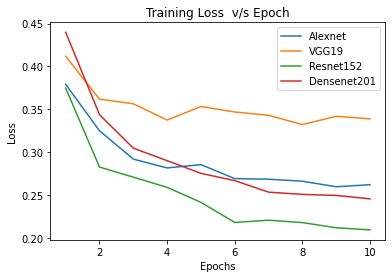

In [32]:
n_epochs = n_e
x = list(range(1,n_epochs+1))

a,b,c,d = alexnet_t_losses, vgg19_t_losses, resnet152_t_losses, densenet201_t_losses


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss  v/s Epoch' )
plt.plot(x,a,label = 'Alexnet')
plt.plot(x,b,label = 'VGG19')
plt.plot(x,c,label = 'Resnet152')
plt.plot(x,d,label = 'Densenet201')
plt.legend()
plt.savefig('training_losses.png')
plt.show()

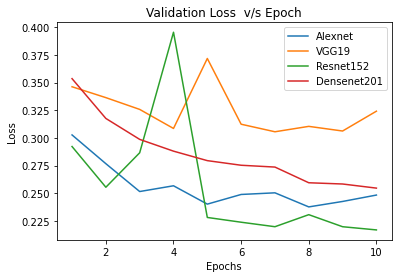

In [33]:
n_epochs = n_e
x = list(range(1,n_epochs+1))

a,b,c,d = alexnet_v_losses, vgg19_v_losses, resnet152_v_losses, densenet201_v_losses






plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss  v/s Epoch' )
plt.plot(x,a,label = 'Alexnet')
plt.plot(x,b,label = 'VGG19')
plt.plot(x,c,label = 'Resnet152')
plt.plot(x,d,label = 'Densenet201')
plt.legend()
plt.savefig('Validation_losses.png')
plt.show()

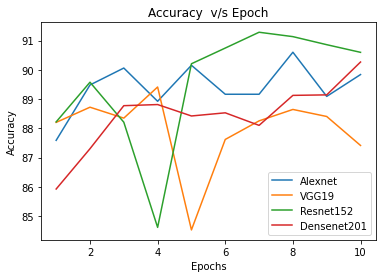

In [34]:
n_epochs = n_e
x = list(range(1,n_epochs+1))

a,b,c,d = alexnet_accuracy, vgg19_accuracy, resnet152_accuracy, densenet201_accuracy






plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy  v/s Epoch' )
plt.plot(x,a,label = 'Alexnet')
plt.plot(x,b,label = 'VGG19')
plt.plot(x,c,label = 'Resnet152')
plt.plot(x,d,label = 'Densenet201')
plt.legend()
plt.savefig('Accuracies.png')
plt.show()

In [35]:
import seaborn as sns


In [36]:
def get_confusion_matrix(model):
  labels_all=[]
  pred_all=[]

  for images, labels in test_dataloader: 
      with torch.no_grad():
        
        if train_on_gpu:  
            images = images.to(device)
            labels = labels.to(device)

        output = model(images)
        ps, pred = torch.max(output, 1)  
      
        labels=labels.cpu()
        labels = labels.numpy()
        pred=pred.cpu()
        pred = pred.numpy()
    

        labels_all+=labels.tolist()
        pred_all+=pred.tolist()


  cf_matrix = confusion_matrix(labels_all, pred_all)
  return cf_matrix

  

In [37]:
alexnet_cf_matrix = get_confusion_matrix(alexnet_model)
vgg19_cf_matrix = get_confusion_matrix(vgg19_model)
resnet152_cf_matrix = get_confusion_matrix(resnet152_model)
densenet201_cf_matrix = get_confusion_matrix(densenet201_model)

Alexnet confusion matrix


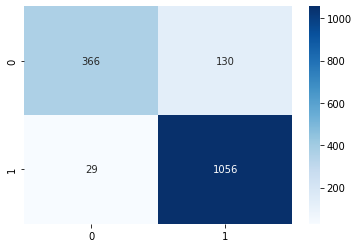

In [38]:
print("Alexnet confusion matrix")
cf_matrix = alexnet_cf_matrix
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')


Alexnet confusion matrix


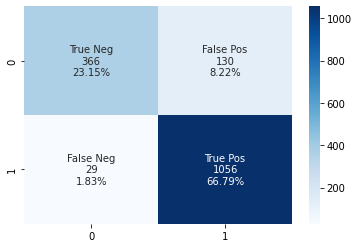

In [39]:
print("Alexnet confusion matrix")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

VGG19 confusion matrix


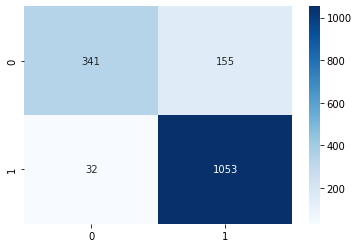

In [40]:
print("VGG19 confusion matrix")
cf_matrix = vgg19_cf_matrix
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')


VGG19 confusion matrix


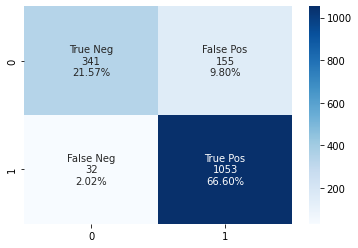

In [41]:
print("VGG19 confusion matrix")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Resnet152 confusion matrix


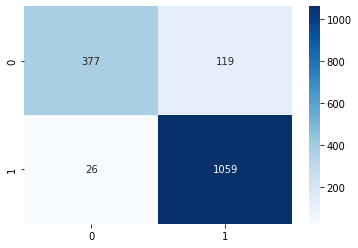

In [42]:
print("Resnet152 confusion matrix")
cf_matrix = resnet152_cf_matrix
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')


Resnet152 confusion matrix


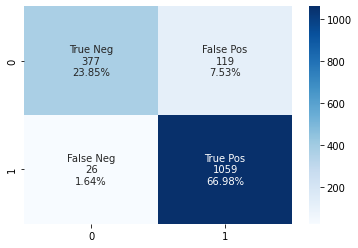

In [43]:
print("Resnet152 confusion matrix")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

Densenet201 confusion matrix


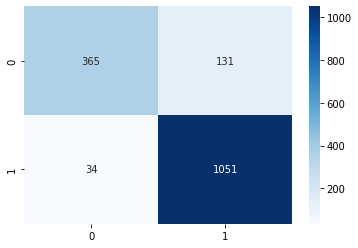

In [44]:
print("Densenet201 confusion matrix")
cf_matrix = densenet201_cf_matrix
sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')


Densenet201 confusion matrix


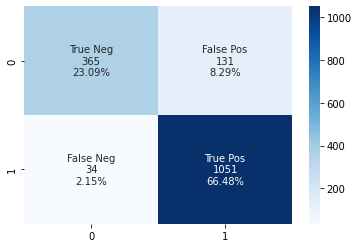

In [45]:
print("Densenet201 confusion matrix")
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [46]:
!zip -r test_set.zip /content/BreaKHis_v1/Test

  adding: content/BreaKHis_v1/Test/ (stored 0%)
  adding: content/BreaKHis_v1/Test/malignant/ (stored 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-17614-400-007.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_PC-14-19440-400-012.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_MC-14-16456-100-079.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-13993-100-015.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_PC-14-15704-200-008.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-17614-40-013.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-17614-40-029.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_MC-14-19979-100-009.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-17614-40-024.png (deflated 0%)
  adding: content/BreaKHis_v1/Test/malignant/SOB_M_DC-14-11520-400-018.png (deflated 0%)
  addin